In [1]:
from keras.models import Model
from keras import backend as K
from keras.layers import LSTM, Input, Dense, Activation, Add, Reshape, Lambda, Concatenate, \
                         TimeDistributed, Bidirectional, Masking

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model

from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from keras.models import load_model

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
from collections import Counter

In [4]:
from sklearn.model_selection import ShuffleSplit
from sklearn.utils import class_weight
from tqdm import tqdm

In [5]:
import numpy as np
np.set_printoptions(precision=3,linewidth=1000,edgeitems=100,suppress=True)
seed = 7
np.random.seed(seed)

In [6]:
docs, links, types = np.load('X_large.npy'), np.load('Ylinks.npy'), np.load('Ytypes.npy')
assert len([i for l in links for i in l]) == sum((len(d) for d in docs))

Counter({5: 71, 6: 24, 4: 11, 3: 3, 7: 2, 10: 1})


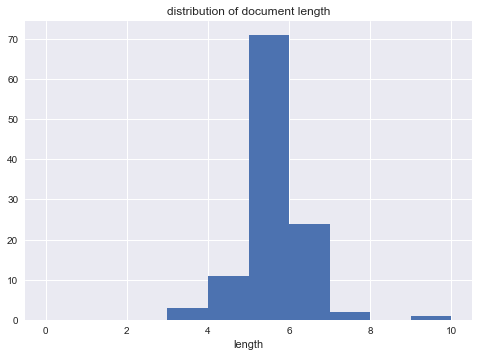

In [7]:
plt.title('distribution of document length')
plt.xlabel('length')
print(Counter([len(d) for d in docs]))
plt.hist([len(d) for d in docs],np.arange(11),);

In [8]:
MAX_LEN = 6
docs_masked = np.array([x for x in docs if len(x) <= MAX_LEN]) # it's not really masking, so maybe think of another name
links_masked = np.array([x for x in links if len(x) <= MAX_LEN]) # it's not really masking, so maybe think of another name
types_masked = np.array([x for x in types if len(x) <= MAX_LEN]) # it's not really masking, so maybe think of another name
print(Counter([len(doc) for doc in docs_masked]))

Counter({5: 71, 6: 24, 4: 11, 3: 3})


Counter({1: 259, 3: 96, 5: 76, 2: 55, 4: 51, 6: 37, 7: 1, 9: 1})


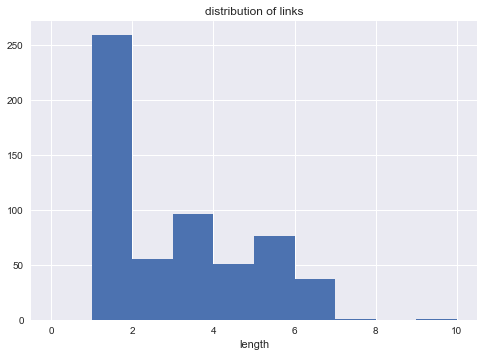

In [9]:
plt.title('distribution of links')
plt.xlabel('length')
print(Counter([i for l in links for i in l]))
plt.hist([i for l in links for i in l],np.arange(11),);

In [10]:
# pad with zeros, truncate longer than 6
X = pad_sequences(docs_masked, dtype=float, truncating='post',padding='post')
print(X.shape)
# convert links 1,1,2 -> [1,0,0,0]
#                        [1,0,0,0]
#                        [0,1,0,0]
#                        [0,0,0,0]
Y = np.array([to_categorical(np.array(y)-1, num_classes=X.shape[1]) for y in links_masked])
Y_ind = [len(y) for y in Y]
Y = pad_sequences(Y, dtype=int, truncating='post', padding='post')

Y_t = [pad_sequences(to_categorical(np.array(y)), truncating='post', padding='post') for y in types_masked]
Y_t = pad_sequences(Y_t, dtype=int, truncating='post', padding='post')

(109, 6, 2641)


In [11]:
X.shape, Y.shape, Y_t.shape

((109, 6, 2641), (109, 6, 6), (109, 6, 2))

In [12]:
# X_train, Y_train = X[:96], Y[:96]
X_test, Y_test, Y_test_ind, Y_t_test = X[100:], Y[100:], Y_ind[100:], Y_t[100:]

X_test.shape, Y_test.shape, Y_t.shape

((9, 6, 2641), (9, 6, 6), (109, 6, 2))

In [13]:
from train import create_model, cv

In [14]:
models = [model for model in cv(docs, links, fold=3, epochs=3, types=types)]

0it [00:00, ?it/s]

OK
Train on 80 samples, validate on 20 samples
Epoch 1/3


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


 - 5s - loss: 17.3177 - link_loss: 1.8219 - type_loss: 0.8035 - link_categorical_accuracy: 0.2771 - type_categorical_accuracy: 0.5769 - val_loss: 13.8154 - val_link_loss: 1.4146 - val_type_loss: 0.8789 - val_link_categorical_accuracy: 0.4917 - val_type_categorical_accuracy: 0.3071
Epoch 2/3


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


 - 2s - loss: 11.7385 - link_loss: 1.6215 - type_loss: 0.7124 - link_categorical_accuracy: 0.1750 - type_categorical_accuracy: 0.6215 - val_loss: 9.4262 - val_link_loss: 1.7076 - val_type_loss: 0.7712 - val_link_categorical_accuracy: 0.1167 - val_type_categorical_accuracy: 0.3071
Epoch 3/3
 - 2s - loss: 7.9157 - link_loss: 1.5857 - type_loss: 0.7006 - link_categorical_accuracy: 0.1125 - type_categorical_accuracy: 0.4575 - val_loss: 6.3540 - val_link_loss: 1.6353 - val_type_loss: 0.6769 - val_link_categorical_accuracy: 0.0917 - val_type_categorical_accuracy: 0.6334


1it [00:16, 16.13s/it]

Train on 80 samples, validate on 20 samples
Epoch 1/3
 - 6s - loss: 17.1925 - link_loss: 1.6963 - type_loss: 0.8561 - link_categorical_accuracy: 0.1500 - type_categorical_accuracy: 0.4137 - val_loss: 13.5224 - val_link_loss: 1.3236 - val_type_loss: 0.7108 - val_link_categorical_accuracy: 0.2500 - val_type_categorical_accuracy: 0.5408
Epoch 2/3
 - 2s - loss: 11.5598 - link_loss: 1.6180 - type_loss: 0.7345 - link_categorical_accuracy: 0.1063 - type_categorical_accuracy: 0.6178 - val_loss: 9.2366 - val_link_loss: 1.6602 - val_type_loss: 0.8572 - val_link_categorical_accuracy: 0.0833 - val_type_categorical_accuracy: 0.3571
Epoch 3/3
 - 2s - loss: 7.6888 - link_loss: 1.5359 - type_loss: 0.7216 - link_categorical_accuracy: 0.1229 - type_categorical_accuracy: 0.4638 - val_loss: 6.0160 - val_link_loss: 1.4755 - val_type_loss: 0.5819 - val_link_categorical_accuracy: 0.0833 - val_type_categorical_accuracy: 0.8583


2it [00:32, 16.26s/it]

Train on 80 samples, validate on 20 samples
Epoch 1/3
 - 7s - loss: 17.2045 - link_loss: 1.6856 - type_loss: 0.9948 - link_categorical_accuracy: 0.2500 - type_categorical_accuracy: 0.4014 - val_loss: 13.4674 - val_link_loss: 1.5268 - val_type_loss: 0.5247 - val_link_categorical_accuracy: 0.0250 - val_type_categorical_accuracy: 0.8413
Epoch 2/3
 - 2s - loss: 11.4752 - link_loss: 1.5757 - type_loss: 0.7526 - link_categorical_accuracy: 0.0833 - type_categorical_accuracy: 0.5796 - val_loss: 9.1827 - val_link_loss: 1.6658 - val_type_loss: 0.9063 - val_link_categorical_accuracy: 0.1000 - val_type_categorical_accuracy: 0.2003
Epoch 3/3
 - 2s - loss: 7.6121 - link_loss: 1.5442 - type_loss: 0.7314 - link_categorical_accuracy: 0.0917 - type_categorical_accuracy: 0.3940 - val_loss: 5.9792 - val_link_loss: 1.5236 - val_type_loss: 0.6380 - val_link_categorical_accuracy: 0.1000 - val_type_categorical_accuracy: 0.6402


3it [00:50, 16.67s/it]

link_macro_f1:0.0965461827941911 (+/- 0.0002467494387348185)
type_macro_f1:0.0 (+/- 0.0)
type_ind_f1:[0. 0.] (+/- [0. 0.])
val_loss:6.116364240646362 (+/- 0.02845069508615931)
val_link_loss:1.5448085069656372 (+/- 0.004482894106163353)
val_type_loss:0.6322871545950571 (+/- 0.0015186124241165623)
val_link_categorical_accuracy:0.09166666989525159 (+/- 4.629631147340694e-05)
val_type_categorical_accuracy:0.7106426457564036 (+/- 0.010914097091856768)
loss:7.738884488741557 (+/- 0.016612403809388197)
link_loss:1.5552930335203807 (+/- 0.00047496441106195973)
type_loss:0.7178703720370928 (+/- 0.0001643470607728897)
link_categorical_accuracy:0.10902778051483135 (+/- 0.00016878858545685887)
type_categorical_accuracy:0.438444409519434 (+/- 0.0009956229233721327)


In [15]:
models[0][1]

defaultdict(list,
            {'link_categorical_accuracy': [0.2770833382382989,
              0.1749999993480742,
              0.11250000353902578],
             'link_loss': [1.821851797401905,
              1.6214796528220177,
              1.585735410451889],
             'link_macro_f1': [0.11500974658869395,
              0.11171355111917725,
              0.11842231842231841],
             'loss': [17.317720413208008,
              11.738530993461609,
              7.915698289871216],
             'type_categorical_accuracy': [0.5768523905426264,
              0.6214604713022709,
              0.45752154663205147],
             'type_ind_f1': [array([0.875, 0.187]),
              array([0., 0.]),
              array([0., 0.])],
             'type_loss': [0.8034750744700432,
              0.7123527228832245,
              0.7006311938166618],
             'type_macro_f1': [0.5312499999999999, 0.0, 0.0],
             'val_link_categorical_accuracy': [0.49166667461395264,
        

In [16]:
[print(i, link) for i, link in enumerate(links)]

0 [5, 1, 5, 5, 5]
1 [3, 3, 3, 3, 3]
2 [1, 1, 2, 1, 1]
3 [3, 3, 3, 3, 4]
4 [1, 1, 1, 1, 4]
5 [1, 1, 1, 1, 1]
6 [2, 3, 3, 3, 4]
7 [5, 1, 2, 2, 5]
8 [1, 1, 1, 1]
9 [1, 1, 1, 3, 1]
10 [1, 1, 1]
11 [4, 4, 4, 4]
12 [1, 1, 1, 1, 1]
13 [1, 1, 1, 1, 1]
14 [1, 1, 1, 1, 1]
15 [3, 3, 5, 5, 5]
16 [1, 1, 1, 1, 1]
17 [3, 3, 5, 5, 5]
18 [2, 6, 4, 6, 6, 6]
19 [6, 6, 6, 6, 6, 6]
20 [1, 1, 4, 1]
21 [1, 1, 1, 1, 1]
22 [3, 3, 3, 5, 3]
23 [1, 1, 1, 1, 4]
24 [3, 3, 3, 3, 3, 3]
25 [1, 1, 1, 1, 1, 1]
26 [1, 1, 1, 3, 1]
27 [1, 1, 1, 3, 3]
28 [1, 1, 2, 1, 1]
29 [1, 1, 1, 1]
30 [1, 1, 1, 1]
31 [1, 1, 1, 1]
32 [1, 1, 1]
33 [1, 1, 1, 1, 4]
34 [5, 5, 5, 5, 5]
35 [1, 1, 2, 3, 1, 1]
36 [1, 1, 1, 1, 1]
37 [1, 3, 1, 1, 1, 1]
38 [1, 1, 2, 1, 1, 1]
39 [1, 1, 2, 1, 1, 5]
40 [1, 1, 1, 1, 1, 5]
41 [4, 4, 4, 4, 4, 5]
42 [1, 1, 1, 3, 3]
43 [4, 4, 2, 4, 4]
44 [2, 5, 5, 5, 5]
45 [5, 5, 5, 5, 5]
46 [5, 3, 5, 5, 5]
47 [5, 3, 5, 5, 5]
48 [3, 3, 5, 5, 5]
49 [6, 3, 6, 6, 6, 6]
50 [3, 3, 3, 3, 3]
51 [5, 5, 4, 5, 5, 5]
52 [2, 6, 4, 2, 

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [17]:
[print(i, link) for i, link in enumerate(models[0].predict(X)[0])]

AttributeError: 'tuple' object has no attribute 'predict'

In [ ]:
np.sum(models[0].predict(X[22:23])[0].argmax(2)[:,:5] == Y[22:23].argmax(2)[:,:5])/5

In [ ]:
models[0].evaluate(X[22:23], [Y[22:23], Y_t[22:23]])

In [ ]:
models[0].metrics_names

In [ ]:
models[0][0].predict(X[22:23])

In [ ]:
Y[22:23].argmax(2)[:5]

In [ ]:
np.sum(models[0].predict(X[20:21])[0].argmax(2)[:5] == Y[20:21].argmax(2)[:5]) / 6

In [ ]:
X_test[2].shape, Y_test[2].shape, Y_t_test[2].shape

In [ ]:
X_test[1:2]

In [ ]:
adam = Adam()
tensorboad = TensorBoard()

In [ ]:
test = []
for i in range(5):
    test.append(histories[0][i].model.evaluate(X[:100],Y[:100]))
test = np.array(test)

In [ ]:
histories[0][0].model.metrics_names

In [ ]:
def mle_loss(y_true, y_pred):
     return tf.square(y_true - y_pred)

In [ ]:
np.mean(test[:,1]), np.var(test[:,1])

In [ ]:
pad_sequences([pad_sequences(to_categorical(np.array(y)-1),maxlen=10) for y in links],maxlen=10)

In [ ]:
params

In [ ]:
histories[0].model

In [ ]:
val_acc = [h.history['val_categorical_accuracy'][-1] for h in histories[0]]
print("{} (+/- {})".format(np.mean(val_acc), np.std(val_acc)))

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
plt.ylim([0.3,1])
x = np.arange(len(histories[0][0].history['val_categorical_accuracy']))
[plt.plot(x,h.history['val_categorical_accuracy'],alpha=.5) for h in histories[0]];
plt.plot(x,np.mean([h.history['categorical_accuracy'] for h in histories[0]],axis=0),c='red', label='training')
plt.plot(x,np.mean([h.history['val_categorical_accuracy'] for h in histories[0]],axis=0),c='black', label='validation')
plt.plot(x,[0.653]*4000, c='yellow', linewidth=10, alpha=.5, label='test')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sns.set_context('talk')
plt.figure(figsize=(15,10))
[plt.plot(np.arange(4000),h.history['val_loss'],alpha=.5) for h in histories[0]];
plt.plot(np.arange(4000),np.mean([h.history['loss'] for h in histories[0]],axis=0),c='red', label='training')
plt.plot(np.arange(4000),np.mean([h.history['val_loss'] for h in histories[0]],axis=0),c='black', label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend();

In [ ]:
model = load_model('4000epoch_0,9dropout_woFC_wBI.h5', custom_objects={'seq_len': seq_len})

In [ ]:
# categorical accuracy (this is a bit skewed since it looks at the each link. 
#                       Since most of them are 0 paddings, accuracy is much higher than it really is...)
model.evaluate(X_test, Y_test)

In [ ]:
X_test, Y_test = X[100:], Y[100:]

In [ ]:
# Real Accuracy... (i.e. ratio of test samples that are completely correct predicted)
#                   not accounting for what has been predicted for the paddings

total_docs = len(Y_test)
total_links = sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

print('document accuracy', sum([np.array_equal(p[:i],y[:i]) for p,y,i in zip(np.argmax(histories[0][3].model.predict(X_test),-1), Y_test.argmax(-1), Y_test_ind)]) / total_docs)
print('link accuracy', sum([sum(p[:i] == y[:i]) for p,y,i in zip(np.argmax(histories[0][3].model.predict(X_test),-1),Y_test.argmax(-1), Y_test_ind)]) / total_links)

In [ ]:
sum([len(y[:i]) for y, i in zip(Y_test.argmax(-1), Y_test_ind)])

In [ ]:
sum([np.array_equal(p,y) for p,y in zip(np.argmax(model.predict(X_test),-1),Y_test.argmax(-1))])

In [ ]:
# compare predictions on training set with training labels
list(zip(models[-1].predict(X_train).argmax(-1), Y_train.argmax(-1)))

In [ ]:
list(zip(model.predict(X_test).argmax(-1), Y_test.argmax(-1)))

In [ ]:
plot_model(model, to_file='model_withoutloop.png')

!open 'model_withoutloop.png'